# Analysis of Monthly Mean Hydrologic Future Variables from LOCA and BCSD

This notebook analyzes hydrologic variables from the historical (1950-2005) and RCP (2006-2100) scenarios from the LOCA and BCSD datasets. 

Variables include:
- Total Runoff
- ET

In [1]:
from loca import print_date
print_date()

Last executed: 2019-05-05 22:12:07.044095 by jvano on r6i6n31


# Imports and Options

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_monthly_cmip_hydro_datasets, resample_monthly_data
from loca.utils import calc_change

# CACHED:
# models = ['ACCESS1-0', 'CanESM2']
# models = ['MIROC5']
# models = ['MRI-CGCM3']
# models = ['bcc-csm1-1']
# models = ['bcc-csm1-1-m']
# models = ['CCSM4']
# models = ['CESM1-BGC']
# models = ['CMCC-CM']
# models = ['GISS-E2-R']
# models = ['HadGEM2-CC']
# models = ['HadGEM2-ES', 'inmcm4']
# models = ['IPSL-CM5A-MR']
# models = ['MIROC-ESM', 'MIROC-ESM-CHEM']
# models = ['MPI-ESM-LR']
# models = ['MPI-ESM-MR']
# models = ['GFDL-ESM2G'] 
# models = ['NorESM1-M']
# models = ['MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4']
# models = ['CESM1-BGC', 'CESM1-CAM5', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC','HadGEM2-ES', 'inmcm4']
# models = ['IPSL-CM5A-MR']
# models = ['MIROC-ESM', 'MIROC-ESM-CHEM']
# models = ['MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M']
# models = ['GFDL-ESM2G']
# models = ['CNRM-CM5']
# models = ['CSIRO-Mk3-6-0']
# models = ['GFDL-ESM2M'] 
# models = ['GFDL-CM3'] 
# models = ['HadGEM2-AO']

# ISSUES:
# models = ['HadGEM2-AO'] # ValueError: zero-size array to reduction operation minimum which has no identity; seems to be ok, though did have warning distributed.client - WARNING - Couldn't gather 60 keys, rescheduling
# models = ['FGOALS-g2'] # correlations not ok.
# models = ['CESM1-CAM5']  # correlations not ok.
# when ran IPSL-CM5A-MR, got error - but restarted kernel and it ran ok # KilledWorker: ('open_dataset-400ff45c9031d93361ea0737b1a2666dbounds_latitude-b94c7aafe69164f36759f70bbaf6b6eb', 'tcp://10.148.0.193:37752')
# models = ['CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']  #previously had issues, but no longer

# models = ['ACCESS1-3'] # no files to open: /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/access1-3_rcp85_r*/*nc
# models = ['CMCC-CMS'] # no files to open: /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/cmcc-cms_rcp85_r*/*nc
# models = ['EC-EARTH'] # no files to open: /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/ec-earth_rcp85_r
# models = ['IPSL-CM5A-LR'] # no files to open: /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/ipsl-cm5a-lr_rcp85_r*/*nc
# models = ['GISS-E2-H'] # /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/giss-e2-h_rcp85_r*/*nc  (error message is a little different, but indicates similar)

# ALL:
# models = ['ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CanESM2', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC5', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M']

# list of 25, without issues:
models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4',
          'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
          'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
          'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

# models = ['ACCESS1-0', 'CanESM2','MIROC5', 'MRI-CGCM3','bcc-csm1-1'] #current 5

hydro_vars = ['ET', 'total_runoff', 'SWE']

In [3]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

<Client: scheduler='tcp://10.148.10.15:55369' processes=72 cores=288>

# Load Data

In [4]:
write_cache = False  

if write_cache:
    xr.set_options(file_cache_maxsize=12000)
    hist_data = load_monthly_cmip_hydro_datasets('historical', models=models, autoclose=False, parallel=True)
    rcp4_data = load_monthly_cmip_hydro_datasets('rcp45', models=models, autoclose=False, parallel=True)
    rcp8_data = load_monthly_cmip_hydro_datasets('rcp85', models=models, autoclose=False, parallel=True)

In [5]:
if write_cache:
    for key, ds in hist_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_hist.{key}_{gcm}.nc'))
    for key, ds in rcp4_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp4.{key}_{gcm}.nc'))
    for key, ds in rcp8_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp8.{key}_{gcm}.nc'))

In [6]:
read_cache = True
hist_data = {}
rcp4_data = {}
rcp8_data = {}
if read_cache:
    for key in ['loca', 'bcsd']:
        hist_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp4_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp4.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp8_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp8.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
print("read from path")
os.path.join(os.environ['TMPDIR'])

read from path


'/glade/scratch/jvano/temp'

hist_epoch


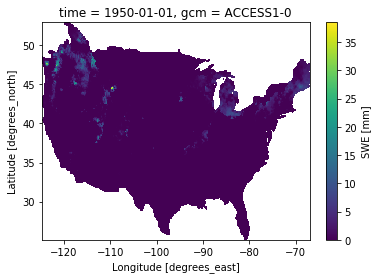

In [11]:
print ('hist_epoch')
hist_data['bcsd']['SWE'].isel(gcm=0, time=0).plot()

In [7]:
display(rcp8_data)

{'loca': <xarray.Dataset>
 Dimensions:       (gcm: 25, lat: 224, lon: 464, time: 1140)
 Coordinates:
   * time          (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2100-12-01
   * lat           (lat) float64 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
   * lon           (lon) float64 -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
   * gcm           (gcm) <U14 'ACCESS1-0' 'CCSM4' ... 'bcc-csm1-1' 'inmcm4'
 Data variables:
     ET            (gcm, time, lat, lon) float32 dask.array<shape=(25, 1140, 224, 464), chunksize=(1, 72, 224, 464)>
     total_runoff  (gcm, time, lat, lon) float32 dask.array<shape=(25, 1140, 224, 464), chunksize=(1, 72, 224, 464)>
     SWE           (gcm, time, lat, lon) float32 dask.array<shape=(25, 1140, 224, 464), chunksize=(1, 72, 224, 464)>,
 'bcsd': <xarray.Dataset>
 Dimensions:       (gcm: 25, lat: 222, lon: 462, time: 1128)
 Coordinates:
   * lat           (lat) float32 25.1875 25.3125 25.4375 ... 52.6875 52.8125
   * time          (time) datetime64[ns]

In [7]:
hist_epoch = slice('1969-10-01', '1999-09-30')
futr_epoch = slice('2069-10-01', '2099-09-30')

mask = hist_data['bcsd']['total_runoff'].isel(gcm=0, time=0).squeeze().notnull()

hist_means = dict((k, resample_monthly_data(ds.sel(time=hist_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in hist_data.items())
rpc4_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp4_data.items())
rpc8_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp8_data.items())

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

In [8]:
# kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
#           'total_runoff': {'vmin': 0, 'vmax': 800},}

kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
          'total_runoff': {'vmin': 0, 'vmax': 1000}, 'SWE': {'vmin': 0, 'vmax': 100},}
units = {'ET': 'mm', 'total_runoff': 'mm', 'SWE': 'mm'}

subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)]

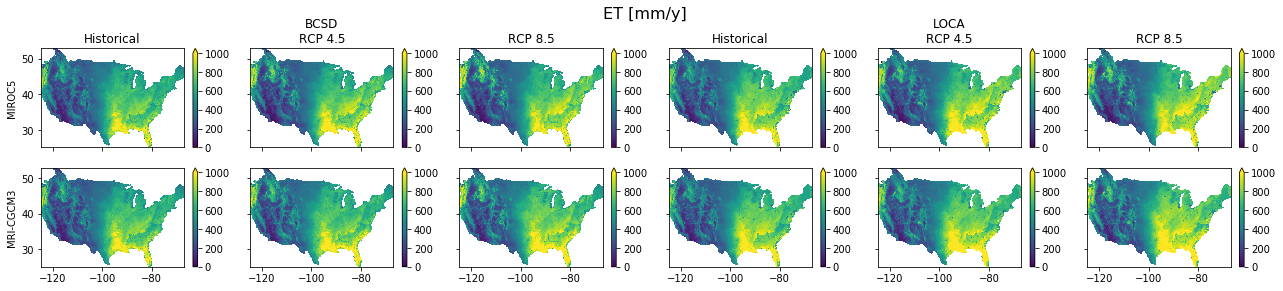

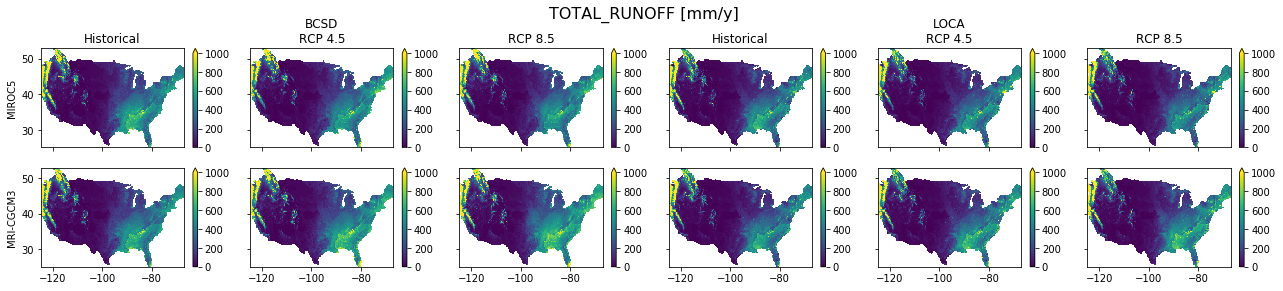

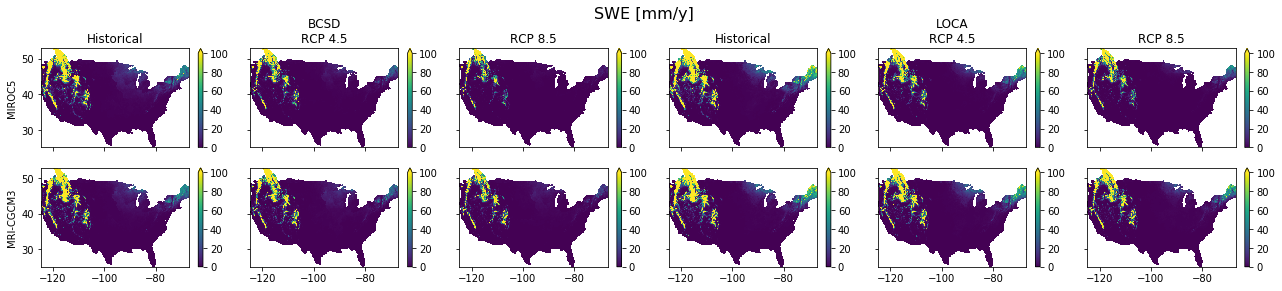

In [41]:
# NOT USING FIG CURRENTLY
# models = ['ACCESS1-0', 'CanESM2']
# models = ['MIROC5', 'MRI-CGCM3']

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
       
    for row, model in enumerate(models):
        for i, dset in enumerate(['bcsd', 'loca']):
            for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
                ax = axes[row, col]
                
                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    if '4.5' in title:
                        title = dset.upper() + '\n' + title
                    ax.set_title(title)
                
                ds_dict[dset][var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
    fig.suptitle(var.upper() + ' [mm/y]', fontsize=16, y=1)
    fig.tight_layout()    

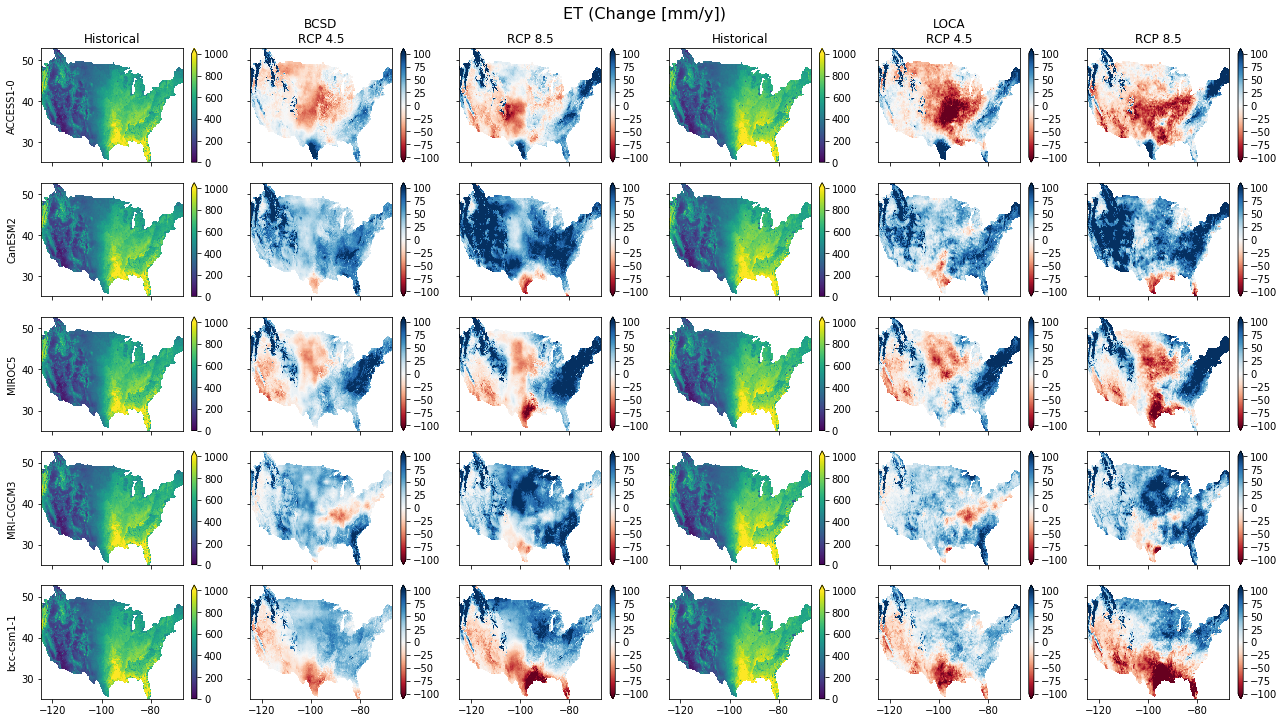

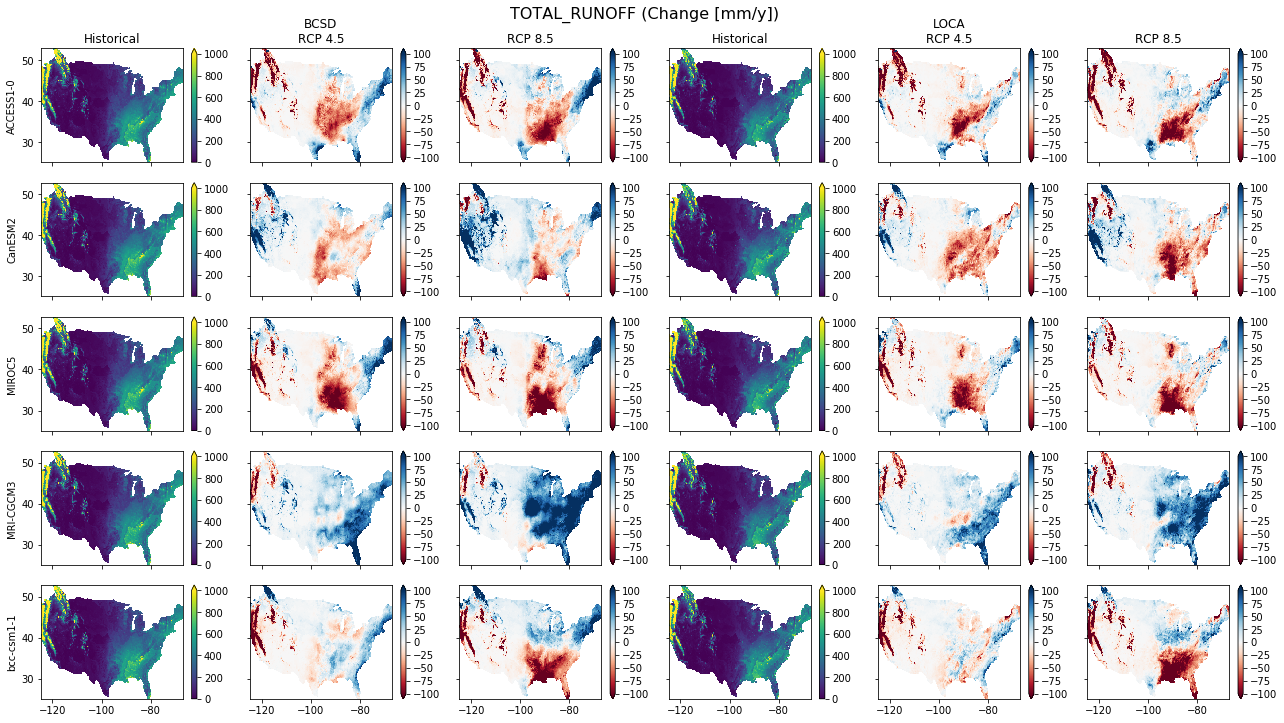

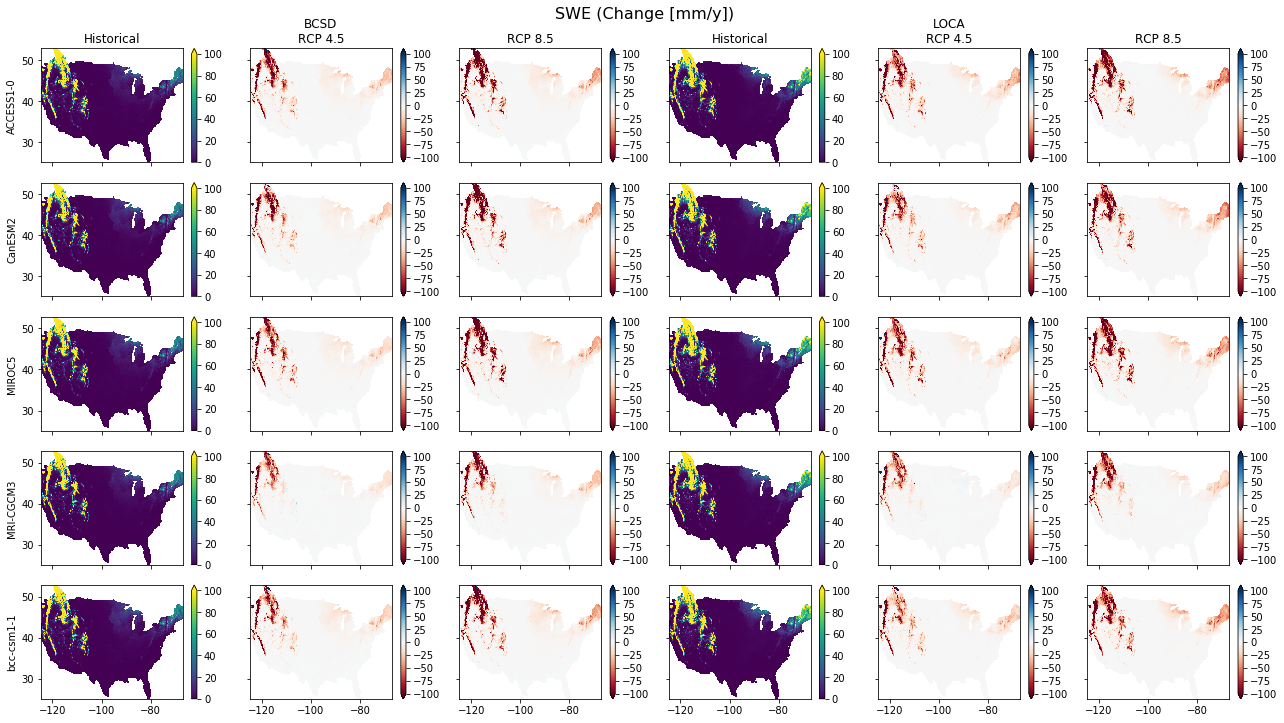

In [11]:
# NOT USING FIG CURRENTLY
diff_kws = {True: {'ET': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                    'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for var in hydro_vars:

    for pct in [False]:
    
        fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
        kws = diff_kws[pct][var]

        for row, model in enumerate(models):
            for i, dset in enumerate(['bcsd', 'loca']):
                for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
                    ax = axes[row, col]

                    if col == 0:
                        ax.set_ylabel(model)
                    if row == 0:
                        if '4.5' in title:
                            title = dset.upper() + '\n' + title
                        ax.set_title(title)
                    if 'RCP' in title:
                        calc_change(hist_means[dset][var].sel(gcm=model),
                                    ds_dict[dset][var].sel(gcm=model),
                                    pct=pct).plot.pcolormesh(ax=ax, add_labels=False, **kws)
                    else:
                        ds_dict[dset][var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

        if pct:
            change_str = ' (% Change)'
            unit_str = 'pct'
        else:
            change_str = ' (Change [mm/y])'
            unit_str = 'mm'
        fig.suptitle(var.upper() + change_str, fontsize=16, y=1)
        fig.tight_layout() 
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')


<xarray.DataArray 'ET' (lat: 222, lon: 462)>
dask.array<shape=(222, 462), dtype=float32, chunksize=(222, 462)>
Coordinates:
  * lat      (lat) float64 25.19 25.31 25.44 25.56 ... 52.44 52.56 52.69 52.81
  * lon      (lon) float64 -124.7 -124.6 -124.4 -124.3 ... -67.31 -67.19 -67.06
    gcm      <U14 'CMCC-CM'
    time     datetime64[ns] 1950-01-16

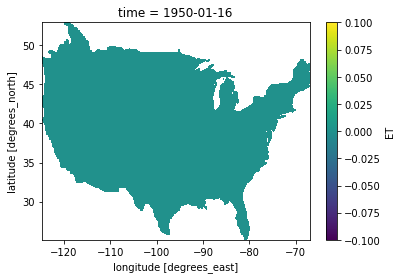

In [60]:
diff['ET'].mean('gcm').plot()
diff['ET'].isel(gcm=3)

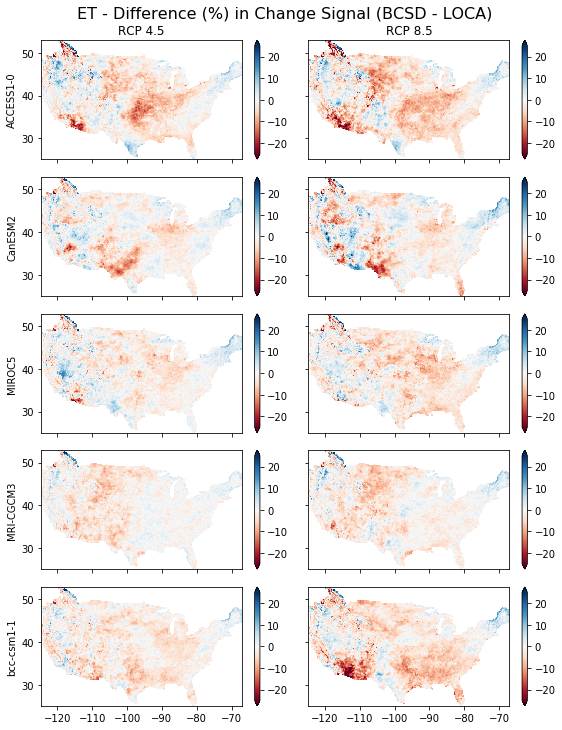

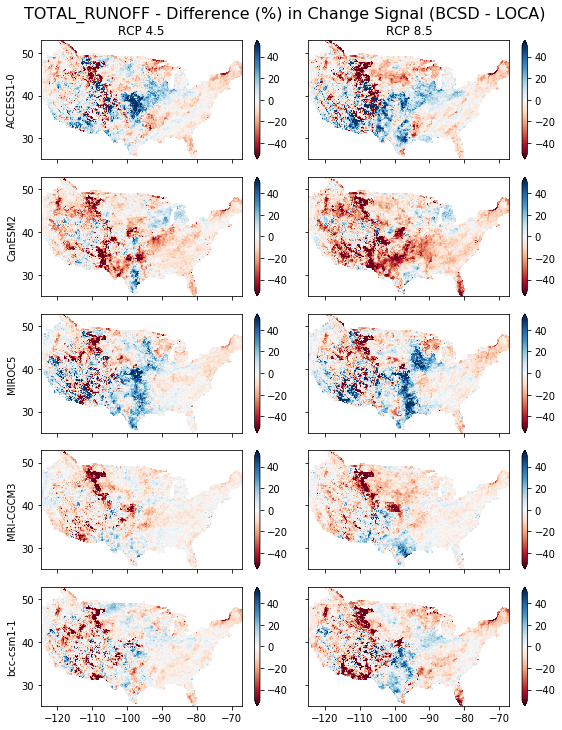

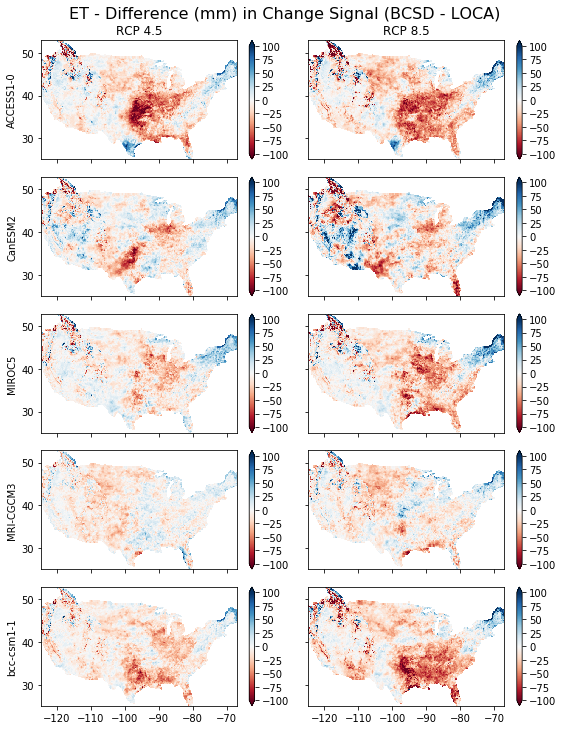

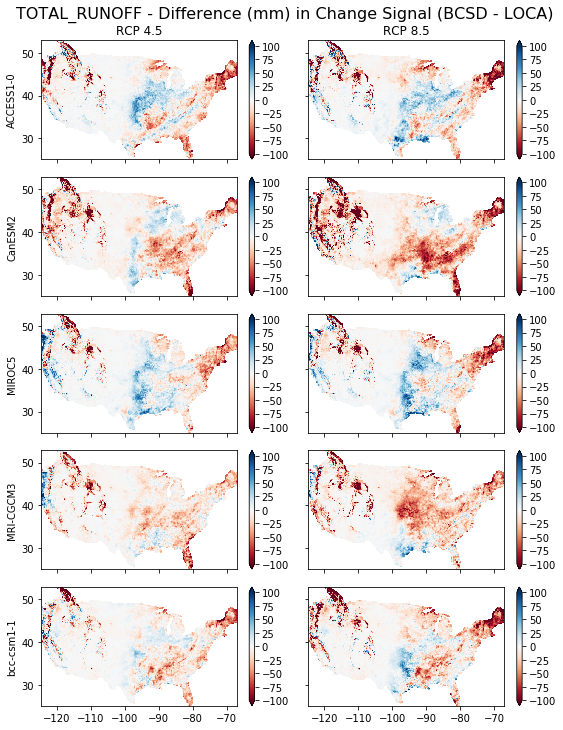

In [19]:
#NOT CURRENTLY USING THIS FIGURE
models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1']

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [True, False]:
    for var in hydro_vars:
        
        if var not in diff_kws[pct]:
            continue

        fig, axes = plt.subplots(ncols=2, nrows=len(models), sharex=True, sharey=True, figsize=(8, 2*len(models)))

        for row, model in enumerate(models):
            for col, (title, ds_dict) in enumerate(subcols[1:]):

                ax = axes[row, col]

                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    ax.set_title(title)                    

                bcsd_diff = calc_change(ds_dict['bcsd'][var].sel(gcm=model),  hist_means['bcsd'][var].sel(gcm=model), pct=pct)
                loca_diff = calc_change(ds_dict['loca'][var].sel(gcm=model),  hist_means['loca'][var].sel(gcm=model), pct=pct)

                (bcsd_diff - loca_diff).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        
        if pct:
            title = var.upper() + " - Difference (%) in Change Signal (BCSD - LOCA)"
            unit_str = 'pct'
        else:
            unit_str = 'mm'
            title = var.upper() + " - Difference (%s) in Change Signal (BCSD - LOCA)" % unit_str
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout() 
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff2_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
        

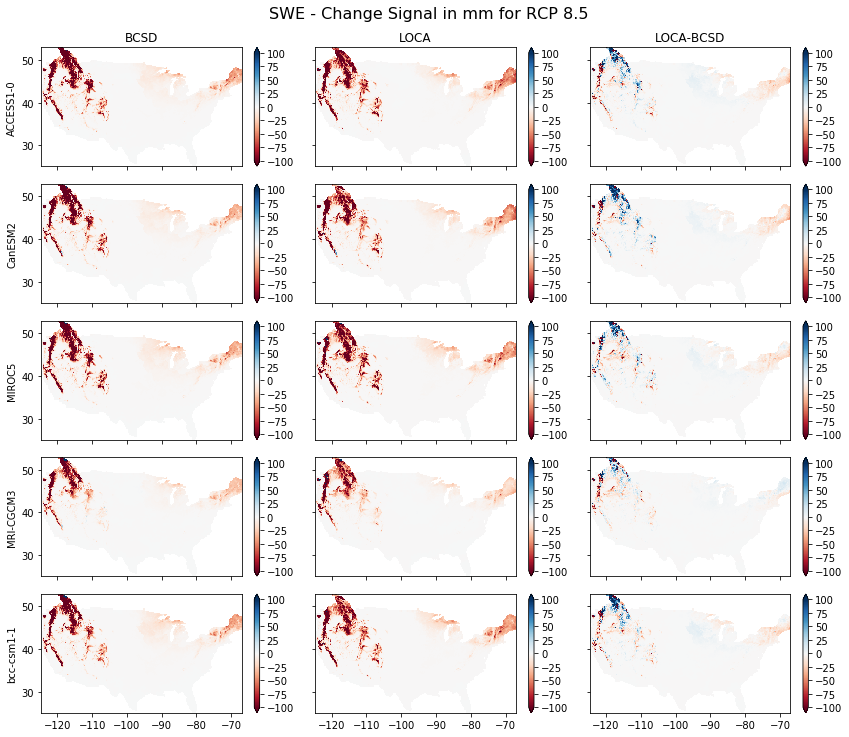

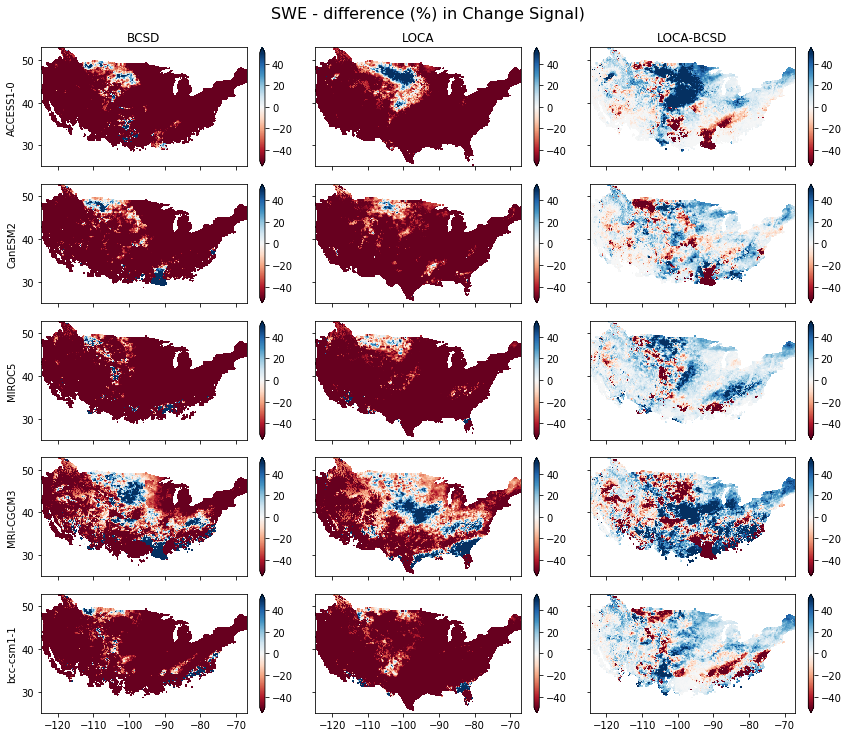

In [13]:
# USE PLOTS K-L
# Plot of change signal with BCSD, LOCA, and LOCA-BCSD

#TODO GET GCM NUMBER IN TITLE
models = ['ACCESS1-0', 'CanESM2','MIROC5', 'MRI-CGCM3','bcc-csm1-1'] #current 5
gcmnum = 'gcm5'

# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CCSM4',
#           'CESM1-BGC', 'CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']
# gcmnum = 'gcm25'


# hydro_vars = ['ET', 'total_runoff', 'SWE']
hydro_vars = ['SWE']
# subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)]
subcols = [('RCP 8.5', rpc8_means)]
# subcols = [('RCP 4.5', rpc4_means)]

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [False, True]:
    for var in hydro_vars:

        
        if var not in diff_kws[pct]:
            continue

        fig, axes = plt.subplots(ncols=3, nrows=len(models), sharex=True, sharey=True, figsize=(12, 2*len(models)))

        for row, model in enumerate(models):
            
            for col, (rcp, ds_dict) in enumerate(subcols[0:]):             

                bcsd_diff = calc_change(hist_means['bcsd'][var].sel(gcm=model), ds_dict['bcsd'][var].sel(gcm=model), pct=pct)
                loca_diff = calc_change(hist_means['loca'][var].sel(gcm=model), ds_dict['loca'][var].sel(gcm=model), pct=pct)

                ax = axes[row, 0]
                bcsd_diff.plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                if row == 0:
                    ax.set_title('BCSD')
                ax.set_ylabel(model)
                
                ax = axes[row, 1]
                loca_diff.plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                if row == 0:
                    ax.set_title('LOCA')
#                     ax.set_title(rcp)
                
                ax = axes[row, 2]
                (loca_diff - bcsd_diff).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                if row == 0:
                    ax.set_title('LOCA-BCSD')
        
        if pct:
            title = var.upper() + " - difference (%) in Change Signal)"
            unit_str = 'pct'
        else:
            unit_str = 'mm'
            title = var.upper() +  " - Change Signal in mm for %s" %rcp
        fig.suptitle(title, fontsize=16, y=1.02)
        fig.tight_layout() 
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{gcmnum}_diff2_{var}_{unit_str}_{rcp}_monthly_future_hydro_change_30WYs.png', dpi=300, bbox_inches='tight')
        

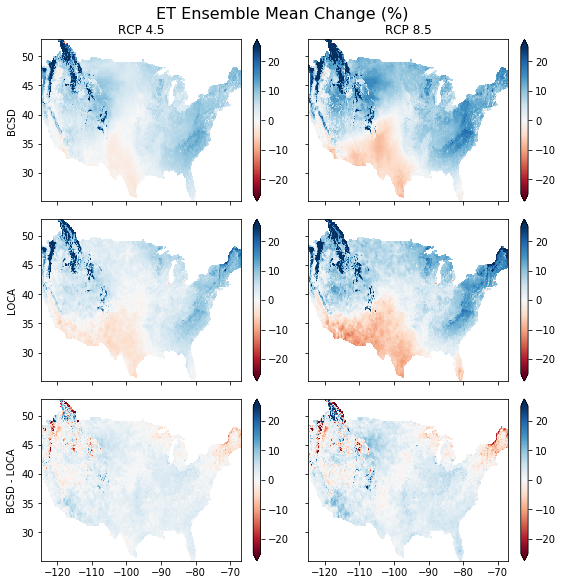

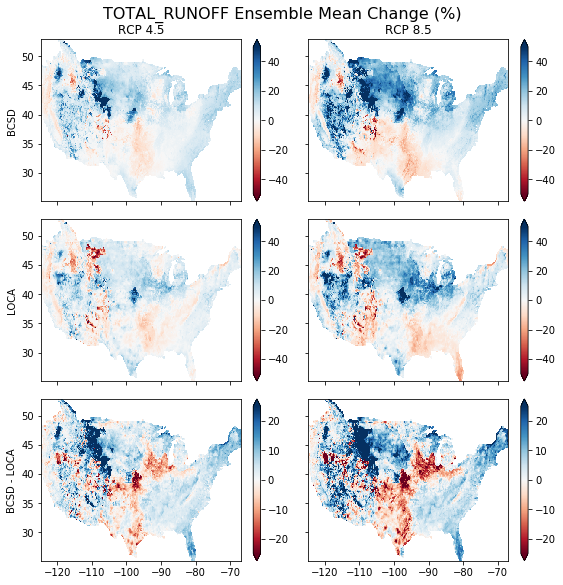

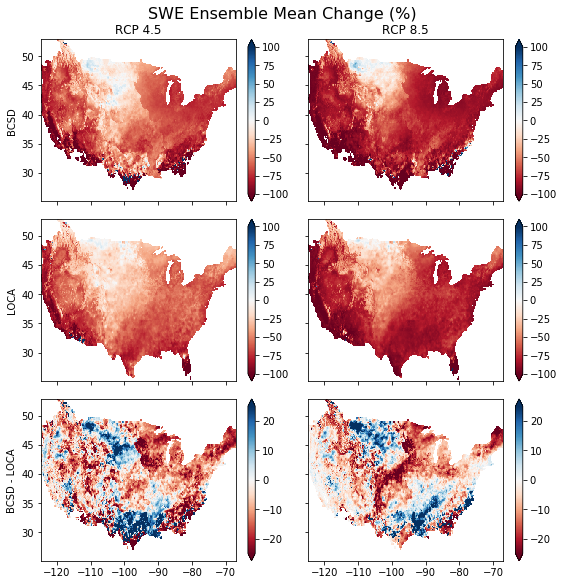

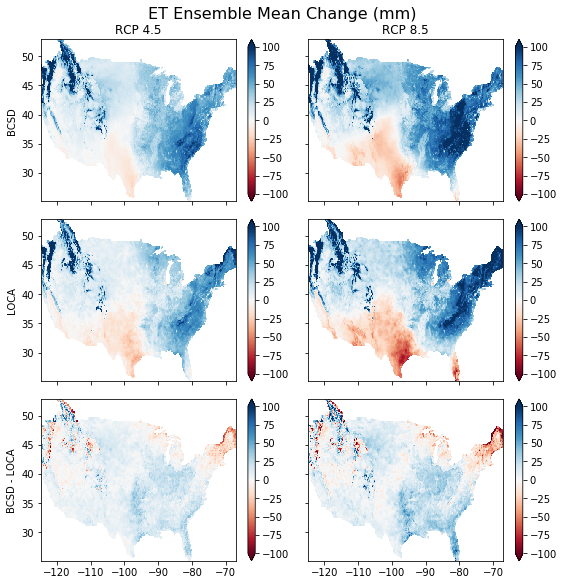

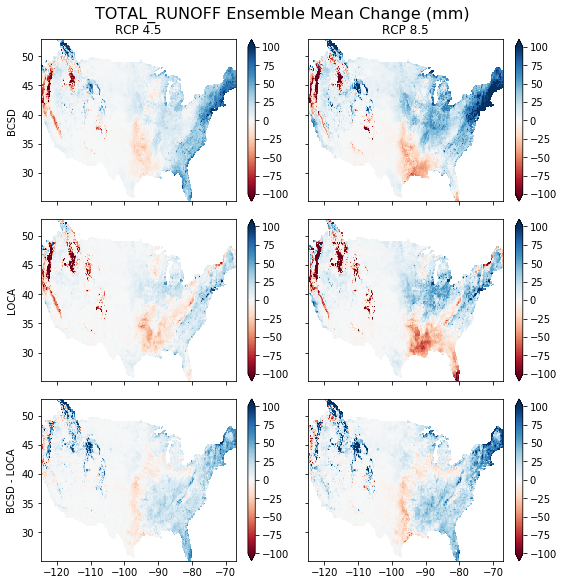

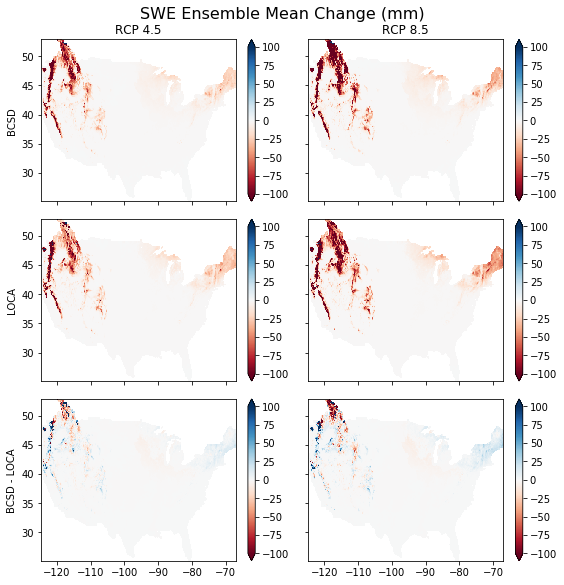

In [14]:
# DON'T USE
cache = {}

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'SWE': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                    'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [True, False]:

    for var in hydro_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(8, 8))

        for col, (title, dsets) in enumerate(subcols[1:]):

            for row, dset in enumerate(['bcsd', 'loca']):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct) #diff between gcms

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(title)
                if col == 0:
                    ax.set_ylabel(dset.upper())

            diff = cache[(row - 1, col)] - cache[(row, col)]
            diff.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])
        axes[-1, 0].set_ylabel('BCSD - LOCA')

    
        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout() 
#         fig.savefig(f'/glade/u/home/jhamman/workdir/loca_figs/diff3_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
        
    

In [48]:
# plt.ens_change(hist_means[dset][var].mean('gcm'))
#subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
#cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(12, 8))

    hist_means['bcsd']['total_runoff'].mean('gcm')
    plt.show()

#.plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])

AttributeError: module 'matplotlib.pyplot' has no attribute 'hist_means'

In [57]:
hist_means['bcsd']['total_runoff'].mean('gcm')

<xarray.DataArray 'total_runoff' (lat: 222, lon: 462)>
dask.array<shape=(222, 462), dtype=float32, chunksize=(222, 462)>
Coordinates:
  * lat      (lat) float32 25.1875 25.3125 25.4375 ... 52.5625 52.6875 52.8125
  * lon      (lon) float32 -124.6875 -124.5625 -124.4375 ... -67.1875 -67.0625
    time     datetime64[ns] 1950-01-16

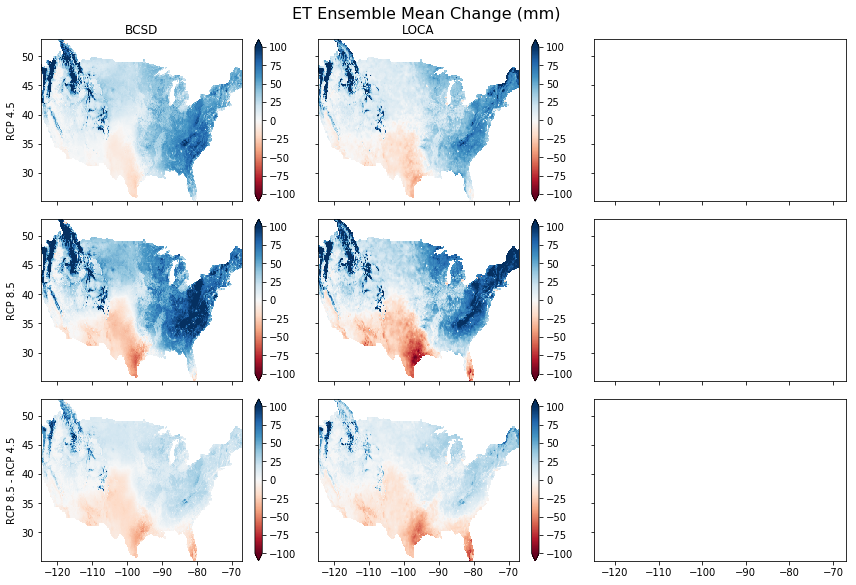

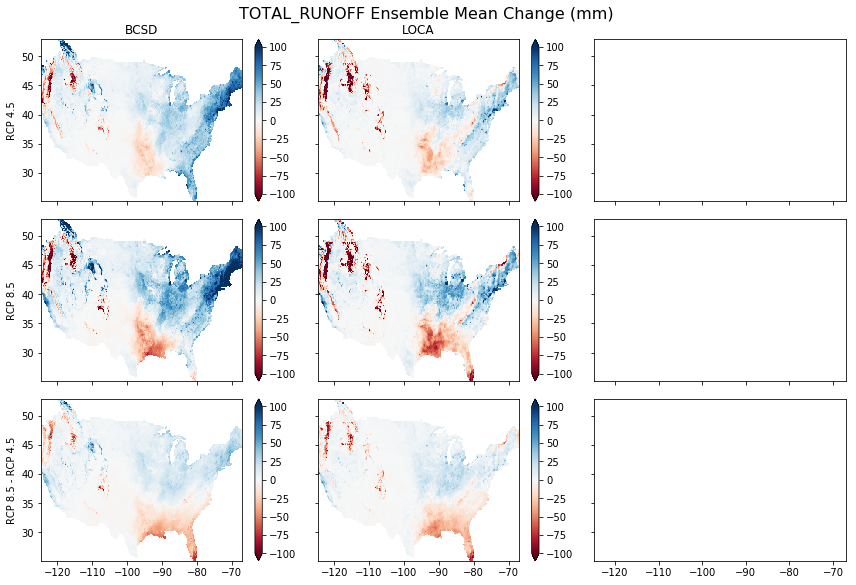

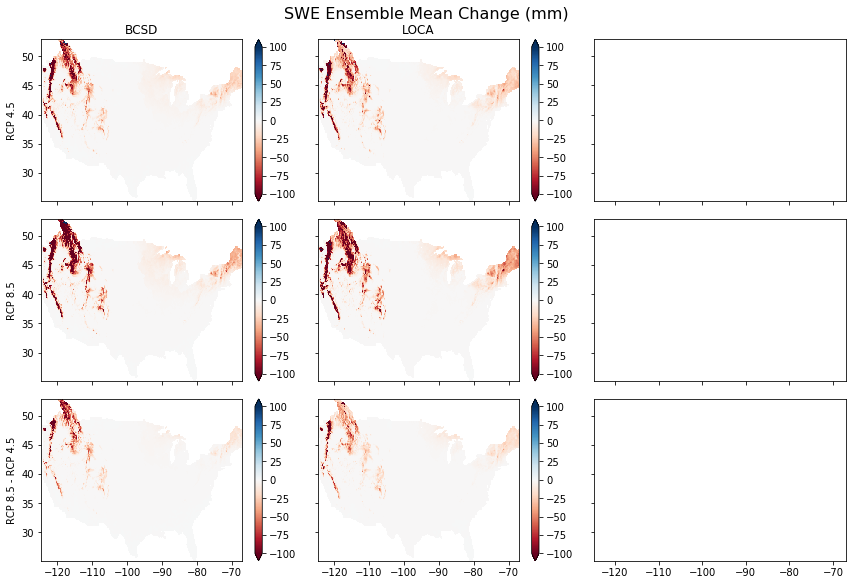

In [14]:
# USE PLOTS M-N

cache = {}

# for testing.  if make all 4.5, diff is zero
subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
hydro_vars = ['ET', 'total_runoff', 'SWE']
# hydro_vars = ['total_runoff']

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'SWE': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                     'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                     'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [False]:

    for var in hydro_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(12, 8))

        for col, dset in enumerate(['bcsd', 'loca']):

            for row, (title, dsets) in enumerate(subcols[1:]):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(dset.upper())
                if col == 0:
                    ax.set_ylabel(title)

            diff = cache[(row, col)] - cache[(row - 1, col)]
            diff.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])
            
#             diff2 = cache[(row, col)] - cache[(row, col - 1)]
#             diff2.plot.pcolormesh(ax=axes[row, col + 1], add_labels=False, **diff2_kws[pct][var])
            
        axes[-1, 0].set_ylabel('RCP 8.5 - RCP 4.5')

        

        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()          
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff4b_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
        

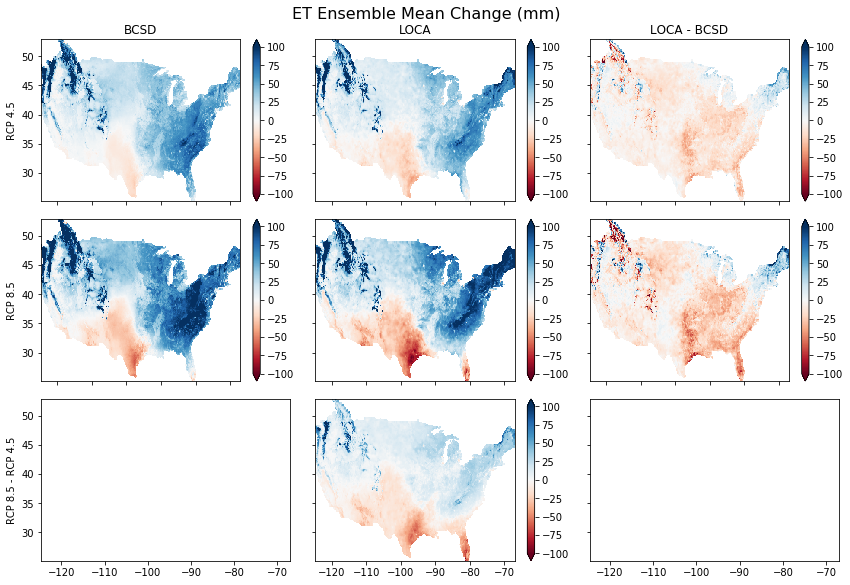

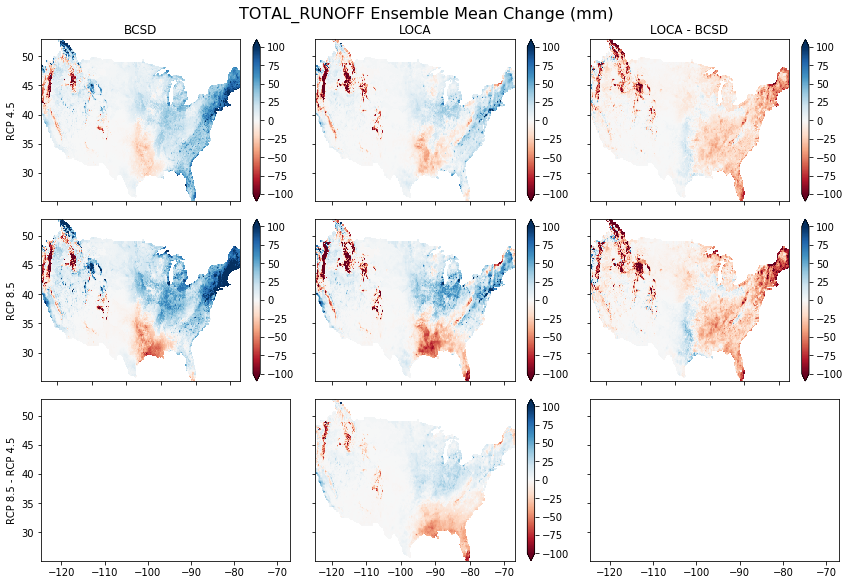

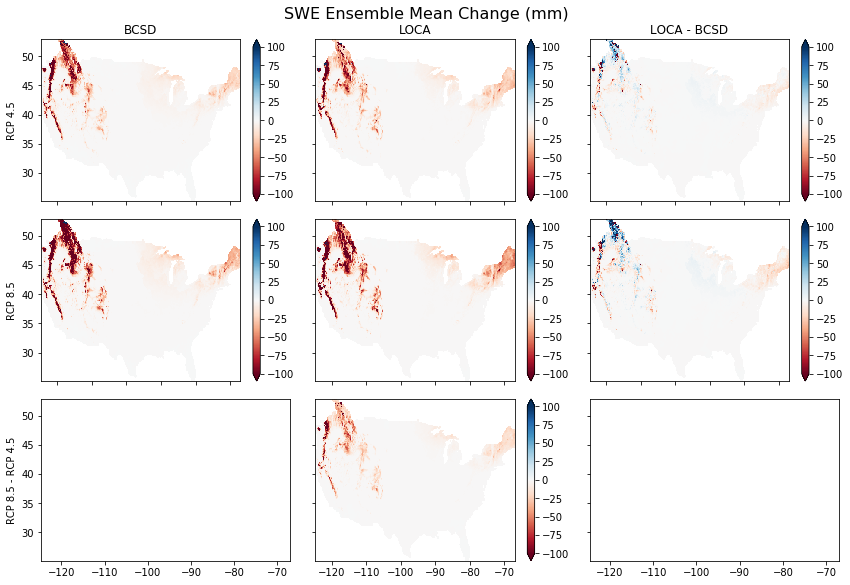

In [15]:
# USE PLOTS M-N

cache = {}

# for testing.  if make all 4.5, diff is zero
subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
hydro_vars = ['ET', 'total_runoff', 'SWE']


diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'SWE': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                     'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                     'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 
for pct in [False]:

    for var in hydro_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(12, 8))

        for row, (title, dsets) in enumerate(subcols[1:]):

            for col, dset in enumerate(['bcsd', 'loca']):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(dset.upper())
                if col == 0:
                    ax.set_ylabel(title)

            diff = cache[(row, col)] - cache[(row, col - 1)]
            diff.plot.pcolormesh(ax=axes[row, col + 1], add_labels=False, **diff2_kws[pct][var])
            axes[0, -1].set_title('LOCA - BCSD')
            
        diff2 = cache[(row, col)] - cache[(row - 1, col)]
        diff2.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])  # only plots second row.  how loop it in?
            
        axes[-1, 0].set_ylabel('RCP 8.5 - RCP 4.5')

    
        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff4a_{var}_{unit_str}_monthly_future_hydro.png', dpi=300, bbox_inches='tight')
        
    

In [16]:
hist_means

{'loca': <xarray.Dataset>
 Dimensions:       (gcm: 25, lat: 222, lon: 462)
 Coordinates:
   * lat           (lat) float64 25.19 25.31 25.44 25.56 ... 52.56 52.69 52.81
   * lon           (lon) float64 -124.7 -124.6 -124.4 ... -67.31 -67.19 -67.06
   * gcm           (gcm) <U14 'ACCESS1-0' 'CCSM4' ... 'bcc-csm1-1' 'inmcm4'
     time          datetime64[ns] 1950-01-01
 Data variables:
     ET            (gcm, lat, lon) float32 dask.array<shape=(25, 222, 462), chunksize=(1, 222, 462)>
     total_runoff  (gcm, lat, lon) float32 dask.array<shape=(25, 222, 462), chunksize=(1, 222, 462)>
     SWE           (gcm, lat, lon) float32 dask.array<shape=(25, 222, 462), chunksize=(1, 222, 462)>,
 'bcsd': <xarray.Dataset>
 Dimensions:       (gcm: 25, lat: 222, lon: 462)
 Coordinates:
   * lat           (lat) float32 25.1875 25.3125 25.4375 ... 52.6875 52.8125
   * lon           (lon) float32 -124.6875 -124.5625 ... -67.1875 -67.0625
   * gcm           (gcm) <U14 'ACCESS1-0' 'CCSM4' ... 'bcc-csm1-1' 'in

In [11]:
plt.close('all')